In [3]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Connecting and Understanding Airline Dataset

In [42]:
connection = sqlite3.connect("./data/travel.sqlite")
cursor = connection.cursor()

tables = cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table'").fetchall()


def knowDataTypes(of_tables, from_cursor):
    for each_table in of_tables:
        print(f"\nTable: {each_table}")
        columns = from_cursor.execute(f"PRAGMA table_info({each_table[0]})").fetchall()
        for column_info in columns:
            print(column_info[1:3])

def checkingNullRows(from_tables, using_connection):
    for each_table in from_tables:
        print(f"\nTable: {each_table}")
        column_info = pd.read_sql_query(f"SELECT * FROM {each_table[0]}", using_connection)
        print(column_info.isnull().sum())

# knowDataTypes(tables, cursor)
# checkingNullRows(tables, connection)



Table: ('aircrafts_data',)
aircraft_code    0
model            0
range            0
dtype: int64

Table: ('airports_data',)
airport_code    0
airport_name    0
city            0
coordinates     0
timezone        0
dtype: int64

Table: ('boarding_passes',)
ticket_no      0
flight_id      0
boarding_no    0
seat_no        0
dtype: int64

Table: ('bookings',)
book_ref        0
book_date       0
total_amount    0
dtype: int64

Table: ('flights',)
flight_id              0
flight_no              0
scheduled_departure    0
scheduled_arrival      0
departure_airport      0
arrival_airport        0
status                 0
aircraft_code          0
actual_departure       0
actual_arrival         0
dtype: int64

Table: ('seats',)
aircraft_code      0
seat_no            0
fare_conditions    0
dtype: int64

Table: ('ticket_flights',)
ticket_no          0
flight_id          0
fare_conditions    0
amount             0
dtype: int64

Table: ('tickets',)
ticket_no       0
book_ref        0
passenger_id

# Q. 1:  Listing the aircraft who have more than 100 seats?

In [46]:
pd.read_sql_query("""   SELECT aircraft_code, COUNT(seat_no) AS seat_counts  
                        FROM seats 
                        GROUP BY aircraft_code 
                        ORDER BY seat_counts DESC
                  """, connection)

,aircraft_code,seat_counts
0,773,402
1,763,222
2,321,170
3,320,140
4,733,130
5,319,116
6,SU9,97
7,CR2,50
8,CN1,12


# Q. 2: Total booked tickets and amount earned over the period of time.

In [49]:
bookings = pd.read_sql_query("""    SELECT * 
                                    FROM tickets 
                                    JOIN bookings USING (book_ref)
                             """, connection)
bookings["book_date"] = pd.to_datetime(bookings["book_date"])

Text(0, 0.5, 'Bookings Count')

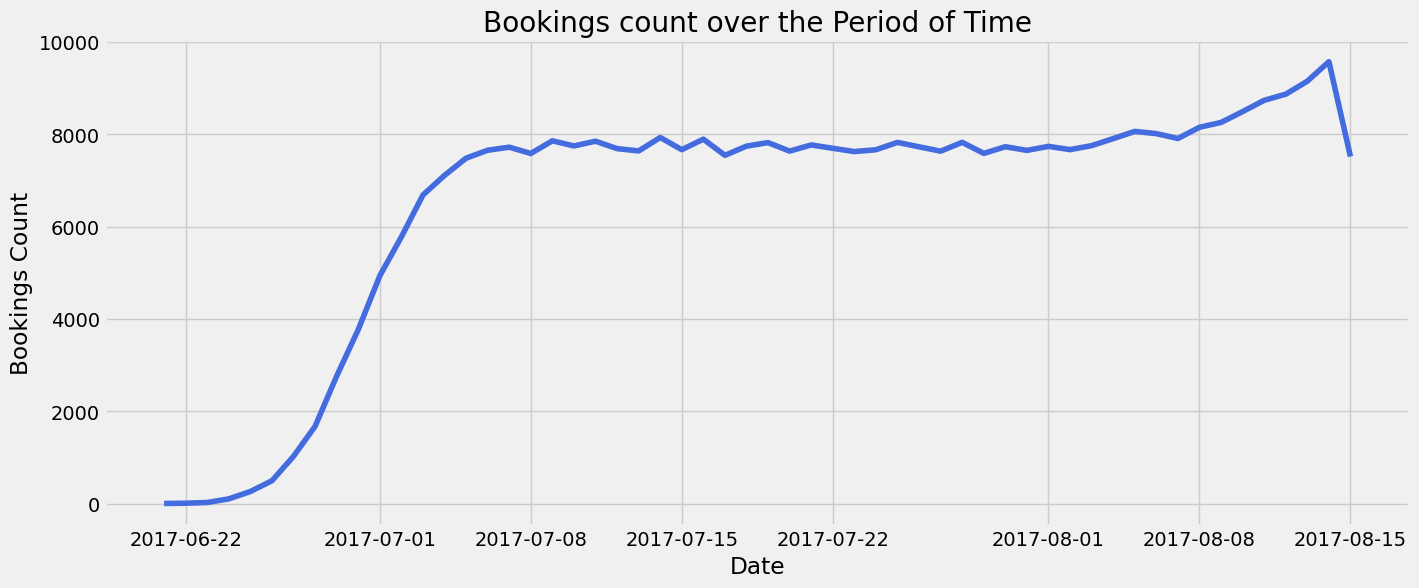

In [52]:
bookings["date"] = bookings["book_date"].dt.date
total_bookings = bookings.groupby("date")["date"].count().reset_index(name = "counts")

plt.style.use("fivethirtyeight")
plt.figure(figsize = (15,6))
plt.title("Bookings count over the Period of Time")
plt.plot(total_bookings["date"], total_bookings["counts"], color = "#456CDF")
plt.xlabel("Date")
plt.ylabel("Bookings Count")

Text(0, 0.5, 'Bookings Amount')

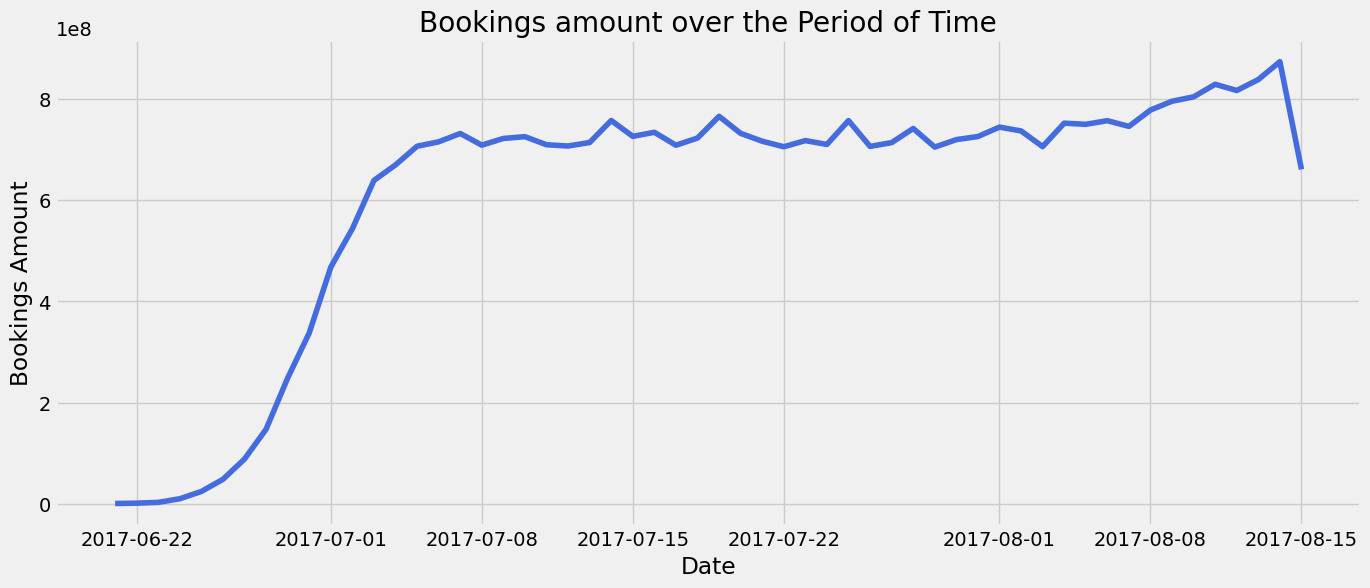

In [57]:
total_amounts = bookings.groupby("date")["total_amount"].sum().reset_index(name = "amount")

plt.style.use("fivethirtyeight")
plt.figure(figsize = (15,6))
plt.title("Bookings amount over the Period of Time")
plt.plot(total_amounts["date"], total_amounts["amount"], color = "#456CDF")
plt.xlabel("Date")
plt.ylabel("Bookings Amount")

# Q. 3: Class wise distribution in each aircraft by average price.

Text(0, 0.5, 'Average Price per Ticket')

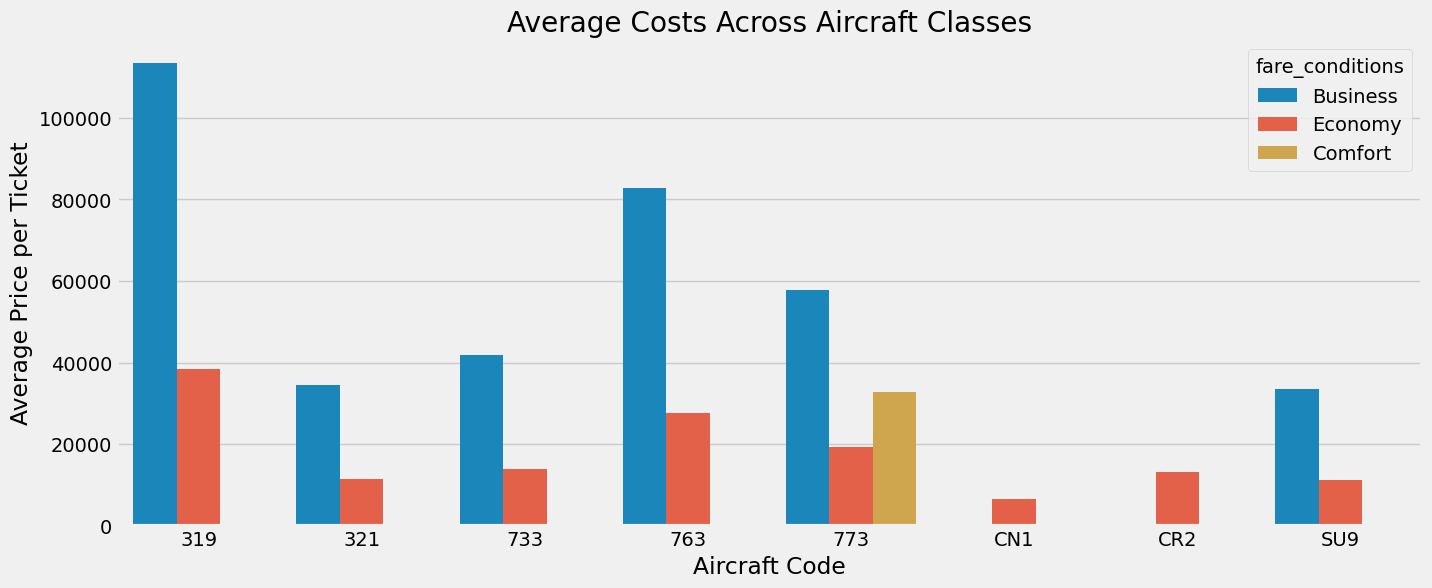

In [88]:
price_by_class = pd.read_sql_query("""   SELECT aircraft_code, fare_conditions, ROUND(AVG(amount), 2) AS avg_price_per_class 
                        FROM ticket_flights 
                        JOIN flights USING (flight_id) 
                        GROUP BY aircraft_code, fare_conditions
                  """, connection)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,6))
plt.title("Average Costs Across Aircraft Classes")
sns.barplot(data = price_by_class, x = price_by_class["aircraft_code"], y = price_by_class["avg_price_per_class"], hue = price_by_class["fare_conditions"])
plt.xlabel("Aircraft Code")
plt.ylabel("Average Price per Ticket")

# Q. 4: Top 5 airports name where people often arrive

In [84]:
pd.read_sql_query("""   SELECT  
                            arrival_airport, COUNT(ticket_no) AS visitor_counts
                        FROM ticket_flights 
                        JOIN flights USING (flight_id)
                        GROUP BY arrival_airport
                        ORDER BY visitor_counts DESC
                        LIMIT 5
                  """, connection)

,arrival_airport,visitor_counts
0,SVO,150086
1,DME,139887
2,LED,66994
3,VKO,60040
4,OVB,47041


# Q. 5: Number of tickets sold, total revenue, and average ticket cost for each aircraft.

In [115]:
aircraft_working = pd.read_sql_query("""   SELECT  
                              aircraft_code, COUNT(ticket_no) AS ticket_sold, 
                              ROUND((SUM(amount)/1e6), 2) AS total_revenue, 
                              ROUND(AVG(amount), 2) AS avg_fare_per_ticket
                        FROM ticket_flights 
                        JOIN flights USING (flight_id)
                        GROUP BY aircraft_code
                  """, connection)
aircraft_working

,aircraft_code,ticket_sold,total_revenue,avg_fare_per_ticket
0,319,52853,2706.16,51201.69
1,321,107129,1638.16,15291.51
2,733,86102,1426.55,16568.16
3,763,124774,4371.28,35033.56
4,773,144376,3431.21,23765.76
5,CN1,14672,96.37,6568.55
6,CR2,150122,1982.76,13207.66
7,SU9,365698,5114.48,13985.54


# Q. 6: Average number of seats booked on each flight for every aircraft.

In [116]:
aircraft_seat_info = pd.read_sql_query("""   SELECT 
                            aircraft_code, ROUND(AVG(occupy_seat)) AS occupy_seat, total_seat
                        FROM (SELECT aircraft_code, COUNT(seat_no) occupy_seat 
                        FROM flights 
                        JOIN boarding_passes USING (flight_id) 
                        GROUP BY aircraft_code, flight_id) AS a
                        JOIN (SELECT aircraft_code, COUNT(seat_no) AS total_seat
                        FROM seats
                        GROUP BY aircraft_code) AS b USING (aircraft_code)
                        GROUP BY aircraft_code
                  """, connection)

aircraft_seat_info["occupancy_rate"] = round((aircraft_seat_info["occupy_seat"] / aircraft_seat_info["total_seat"]), 2)
aircraft_seat_info["increased_occupancy_rate_10%"] = round(aircraft_seat_info["occupancy_rate"] + aircraft_seat_info["occupancy_rate"] * .10, 2)
aircraft_seat_info

,aircraft_code,occupy_seat,total_seat,occupancy_rate,increased_occupancy_rate_10%
0,319,54.0,116,0.47,0.52
1,321,89.0,170,0.52,0.57
2,733,80.0,130,0.62,0.68
3,763,114.0,222,0.51,0.56
4,773,265.0,402,0.66,0.73
5,CN1,6.0,12,0.50,0.55
6,CR2,21.0,50,0.42,0.46
7,SU9,57.0,97,0.59,0.65


# Forecasting revenue for the airlines

In [126]:
projected_revenue = aircraft_working[['aircraft_code', 'total_revenue']]
projected_revenue["expected_revenue"] = round((projected_revenue["total_revenue"] / aircraft_seat_info["occupancy_rate"]) * aircraft_seat_info["increased_occupancy_rate_10%"], 2)
projected_revenue

,aircraft_code,total_revenue,expected_revenue
0,319,2706.16,2994.05
1,321,1638.16,1795.68
2,733,1426.55,1564.60
3,763,4371.28,4799.84
4,773,3431.21,3795.13
5,CN1,96.37,106.01
6,CR2,1982.76,2171.59
7,SU9,5114.48,5634.60
